In [1]:
%pip install gdown

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/cb/56/f4845ed78723a4eb8eb22bcfcb46e1157a462c78c0a5ed318c68c98f9a79/gdown-5.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for beautifulsoup4 from https://files.pythonhosted.org/packages/b1/fe/e8c672695b37eecc5cbf43e1d0638d88d66ba3a44c4d321c796f4e59167f/beautifulsoup4-4.12.3-py3-none-any.whl.metadata
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for soupsieve>1.2 from https://files.pythonhosted.org/packages/4c/f3/038b302fdfbe3be7da016777069f26ceefe11a681055ea1f7817546508e3/soupsieve-2.5-py3-none-any.whl.metadata
  Using cached soupsieve-2.5-py3-none-any.whl.metadata (4.7 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached soupsieve-2.5-py3-none-any.whl (36 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run

In [4]:
!gdown https://drive.google.com/u/0/uc?id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45&export=download

zsh:1: no matches found: https://drive.google.com/u/0/uc?id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45


In [5]:
!tar -xf ./CUB_200_2011.tgz

tar: Error opening archive: Failed to open './CUB_200_2011.tgz'


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()

## Train Test Split

In [ ]:
read_line = open('./CUB_200_2011/train_test_split.txt')

In [ ]:
a = read_line.readlines()

In [ ]:
a[0].split(' ')[1].split('\n')[0]

'0'

In [ ]:
classes = open('./CUB_200_2011/classes.txt')
c_names = classes.readlines()
len(c_names)

200

In [ ]:
for i in range(len(c_names)):
    c_names[i] = c_names[i].split(' ')[1]

In [ ]:
c_names[0].split('\n')[0]

'001.Black_footed_Albatross'

In [ ]:
import os
for i in range(len(c_names)):
    os.makedirs('./test/'+c_names[i].split('\n')[0])

In [ ]:
train_dataset = datasets.ImageFolder('./CUB_200_2011/images')

In [ ]:
from skimage import io

In [ ]:
print(train_dataset.imgs[0][0].split('/'))

['.', 'CUB_200_2011', 'images', '001.Black_footed_Albatross', 'Black_Footed_Albatross_0001_796111.jpg']


In [ ]:
for j in range(len(train_dataset.imgs)):
    if(a[j].split(' ')[1].split('\n')[0] == '0'):
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0].split('/')[3]
        img_name = train_dataset.imgs[j][0].split('/')[4]
        io.imsave('./test/'+folder+'/'+img_name,img)
        os.remove(path)

In [ ]:
!mkdir train

In [ ]:
!cp -r ./CUB_200_2011/images/* ./train/

## Learning Part

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '.'
# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(dataset_sizes)

{'train': 5994, 'test': 5794}


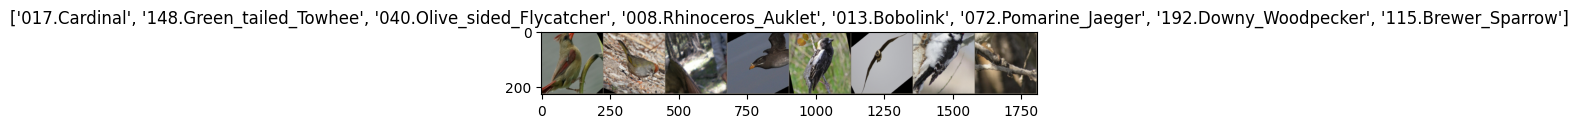

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
!mkdir Bird

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'./Bird/point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()


    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [ ]:
model_ft = models.resnet18() # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories

if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6565 Acc: 0.0163
test Loss: 0.6606 Acc: 0.0269

Epoch 1/49
----------
train Loss: 0.6171 Acc: 0.0245
test Loss: 0.6397 Acc: 0.0394

Epoch 2/49
----------
train Loss: 0.5990 Acc: 0.0315
test Loss: 0.6176 Acc: 0.0449

Epoch 3/49
----------
train Loss: 0.5854 Acc: 0.0454
test Loss: 0.5694 Acc: 0.0566

Epoch 4/49
----------
train Loss: 0.5701 Acc: 0.0511
test Loss: 0.5810 Acc: 0.0632

Epoch 5/49
----------
train Loss: 0.5555 Acc: 0.0651
test Loss: 0.5493 Acc: 0.0770

Epoch 6/49
----------
train Loss: 0.5468 Acc: 0.0681
test Loss: 0.5414 Acc: 0.0975

Epoch 7/49
----------
train Loss: 0.5350 Acc: 0.0809
test Loss: 0.5365 Acc: 0.0965

Epoch 8/49
----------
train Loss: 0.5219 Acc: 0.0921
test Loss: 0.4976 Acc: 0.1298

Epoch 9/49
----------
train Loss: 0.5111 Acc: 0.1048
test Loss: 0.4736 Acc: 0.1450

Epoch 10/49
----------
train Loss: 0.5004 Acc: 0.1223
test Loss: 0.4652 Acc: 0.1600

Epoch 11/49
----------
train Loss: 0.4956 Acc: 0.1248
test Loss: 0.4580 Acc: 0.1660

Epoch 12/49
